# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [3]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
%pip install umap
%pip install umap-learn

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=33adffd0a8005a00a130a139fe70d7aa695a1d1cbf8857460ceeac1bbf65a59d
  Stored in directory: /home/piquelinxbox/.cache/pip/wheels/48/4a/1c/1d511cbb0413a448d8546e958f8e82b98d9bb493038d19ece2
Successfully built umap
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

/home/piquelinxbox/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-04 20:58:06.740672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 20:58:08.970785: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 20:58:09.736993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 20:58:10.637092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 20:58:10.9359

In [7]:
#base_path = 'E:/Users/Piquelin/Documents/Maestría_DataMining/Economia_y_finanzas/'
base_path = '~/buckets/b1/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

In [8]:
df_train = pd.read_csv(dataset_path + dataset_file)

/tmp/ipykernel_5921/1471967834.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(dataset_path + dataset_file)


Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [9]:
df_train = df_train[df_train['foto_mes']==202104]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [10]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [11]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [38]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf.iloc[:,1:])

model = RandomForestClassifier(n_estimators=200, max_features=20, min_samples_leaf=400, random_state=17 )
model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_features=20, min_samples_leaf=400, n_estimators=200,
                       random_state=17)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [39]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [40]:
md

array([[0.   , 0.54 , 0.815, ..., 0.975, 0.98 , 0.985],
       [0.54 , 0.   , 0.925, ..., 0.955, 0.98 , 0.99 ],
       [0.815, 0.925, 0.   , ..., 0.765, 0.78 , 0.995],
       ...,
       [0.975, 0.955, 0.765, ..., 0.   , 0.145, 0.36 ],
       [0.98 , 0.98 , 0.78 , ..., 0.145, 0.   , 0.255],
       [0.985, 0.99 , 0.995, ..., 0.36 , 0.255, 0.   ]])

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

/home/piquelinxbox/.venv/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/piquelinxbox/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


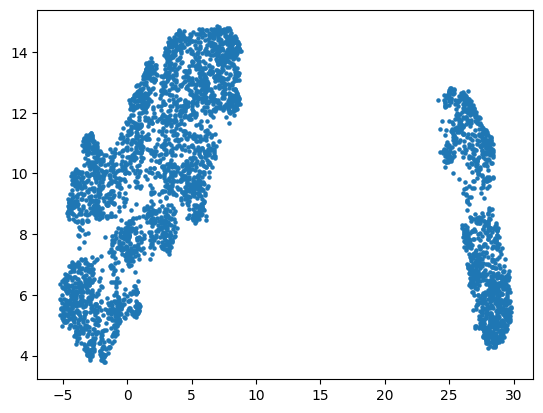

In [46]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=150,
  min_dist=0.6,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], s=5)

In [47]:
model_copia = model

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

In [48]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model_copia.predict_proba(Xtrain_rf_imp)[:,class_index]

hdb = DBSCAN(eps=0.27)
y = hdb.fit(embedding_rf)


Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

In [49]:
y.labels_.shape

(4176,)

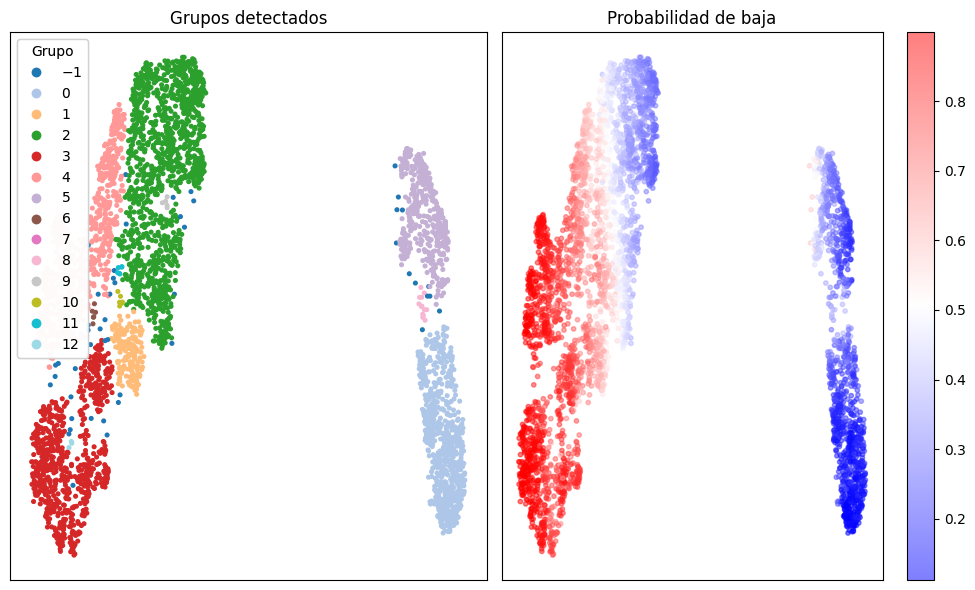

In [50]:

fig, axs = plt.subplots(1,2, figsize=(10,6))

scatter = axs[0].scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab20', s=7, alpha=1)
# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),
                    loc="upper left", title="Grupo")
axs[0].add_artist(legend1)
axs[0].set_title('Grupos detectados')

prop = axs[1].scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja, s=10,  cmap='bwr', alpha=0.5)
fig.colorbar(prop, ax=axs[1] )
axs[1].set_title('Probabilidad de baja')

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

fig.tight_layout()
fig.savefig('clusters.png', dpi=92)
plt.show()

#        for i, c in enumerate(centers):
#            ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=30, edgecolor="k")

Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

In [21]:
clases_cant = pd.DataFrame(y.labels_).value_counts()
proporcion = (clases_cant/clases_cant.sum())*100
clases_ca_pro = pd.concat([clases_cant, proporcion], axis=1)

In [22]:
clases_ca_pro.sort_index()

,count,count
0,,
-1,49,1.173372
0,716,17.145594
1,163,3.903257
2,1296,31.034483
3,755,18.079502
4,756,18.103448
5,395,9.458812
6,6,0.143678
7,7,0.167625


Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

In [23]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  model.fit(Xtrain_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Y exploramos cuales son las variables importantes por cada cluster

In [24]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:10]:
    print(f"  - {feature}")


Cluster 2 vs. Resto:
  - ccaja_seguridad
  - cpayroll_trx
  - matm_other
  - ctarjeta_visa
  - mactivos_margen
  - ccaja_ahorro
  - ctarjeta_visa_transacciones
  - mtarjeta_master_descuentos
  - ccomisiones_mantenimiento
  - mrentabilidad_annual
Cluster 0 vs. Resto:
  - cpayroll_trx
  - ccaja_seguridad
  - Visa_Finiciomora
  - Visa_msaldototal
  - ctarjeta_visa_transacciones
  - ctarjeta_visa
  - ccomisiones_mantenimiento
  - mtarjeta_master_descuentos
  - Visa_cadelantosefectivo
  - Visa_mpagado
Cluster 1 vs. Resto:
  - ccaja_ahorro
  - matm_other
  - mactivos_margen
  - cdescubierto_preacordado
  - mcuenta_corriente_adicional
  - Visa_msaldototal
  - ctarjeta_visa_transacciones
  - Visa_Finiciomora
  - ctarjeta_debito
  - mcomisiones
Cluster 3 vs. Resto:
  - matm_other
  - mautoservicio
  - ctarjeta_visa
  - ccaja_ahorro
  - mpasivos_margen
  - Visa_msaldototal
  - Visa_cadelantosefectivo
  - mactivos_margen
  - mtarjeta_visa_consumo
  - cdescubierto_preacordado
Cluster 4 vs. Resto:


In [25]:
important_df = pd.DataFrame.from_dict(important_features_by_cluster)
df_grupos = important_df[:5].T.sort_index()
df_grupos.index = pd.Index(df_grupos.index, name='grupo')
df_grupos

,0,1,2,3,4
grupo,,,,,
-1,Visa_mfinanciacion_limite,mrentabilidad_annual,Visa_mpagado,Visa_mpagosdolares,ccomisiones_otras
0,cpayroll_trx,ccaja_seguridad,Visa_Finiciomora,Visa_msaldototal,ctarjeta_visa_transacciones
1,ccaja_ahorro,matm_other,mactivos_margen,cdescubierto_preacordado,mcuenta_corriente_adicional
2,ccaja_seguridad,cpayroll_trx,matm_other,ctarjeta_visa,mactivos_margen
3,matm_other,mautoservicio,ctarjeta_visa,ccaja_ahorro,mpasivos_margen
4,matm_other,ccaja_ahorro,Visa_Finiciomora,Visa_msaldototal,mactivos_margen
5,cpayroll_trx,ccaja_seguridad,Visa_msaldototal,Visa_Finiciomora,ctarjeta_visa_transacciones
6,Visa_Finiciomora,internet,mrentabilidad_annual,ccomisiones_otras,mcomisiones
7,mactivos_margen,cliente_antiguedad,cdescubierto_preacordado,Visa_mpagosdolares,mcomisiones


In [26]:
a = df_grupos.unstack().unique()

In [27]:
for i in  range(len(df_grupos.T)):
    print('grupo', df_grupos.index[i])
    for j in range(len(df_grupos.T[i])):
        print(df_grupos.T.iloc[i, j])


grupo -1
Visa_mfinanciacion_limite
cpayroll_trx
ccaja_ahorro
ccaja_seguridad
matm_other
grupo 0
mrentabilidad_annual
ccaja_seguridad
matm_other
cpayroll_trx
mautoservicio
grupo 1
Visa_mpagado
Visa_Finiciomora
mactivos_margen
matm_other
ctarjeta_visa
grupo 2
Visa_mpagosdolares
Visa_msaldototal
cdescubierto_preacordado
ctarjeta_visa
ccaja_ahorro
grupo 3
ccomisiones_otras
ctarjeta_visa_transacciones
mcuenta_corriente_adicional
mactivos_margen
mpasivos_margen


In [28]:
import pandas as pd
import numpy as np

# Supongamos que tienes otro DataFrame `df_datos` con los datos reales de esos campos para cada grupo:
# Por ejemplo:
Xtrain_rf.iloc[:,1:]
df_datos = pd.DataFrame( Xtrain_rf_imp, columns=Xtrain_rf.iloc[:,1:].columns)
df_datos['grupo'] = y.labels_


# Ahora para calcular las estadísticas:
estadisticas = []

# Iterar sobre las columnas que quieres analizar
for col in df_datos[list(df_grupos.unstack().unique())]:  # Excluye 'grupo'

    datos_grupo = df_datos.groupby('grupo')[col].apply(lambda x: {
        'promedio': x.mean(),
        'mediana': x.median(),
        'decil_25': np.percentile(x, 25),
        'decil_50': np.percentile(x, 50),
        'decil_75': np.percentile(x, 75)
    })
    

    tabla_col = pd.DataFrame(datos_grupo).reset_index().pivot_table(index='grupo', columns='level_1', values=col)
    indice= pd.MultiIndex.from_tuples([(col, x) for x in tabla_col.columns])
    tabla_col.columns =indice
    estadisticas.append(tabla_col)




In [29]:
tabla_features = pd.concat(estadisticas, axis=1)
tabla_features.to_csv('tabla_features.csv', sep=';')

In [30]:
importancias_tabla = pd.get_dummies(important_df[:5].unstack())
important_df[:5].unstack().value_counts()

matm_other                     5
mactivos_margen                5
Visa_Finiciomora               5
ccaja_ahorro                   5
Visa_msaldototal               4
mcuenta_corriente_adicional    4
ctarjeta_visa_transacciones    3
ccaja_seguridad                3
cpayroll_trx                   3
cdescubierto_preacordado       3
Visa_mpagosdolares             3
ccomisiones_otras              3
mcomisiones                    3
internet                       2
Visa_mfinanciacion_limite      2
ctarjeta_visa                  2
mrentabilidad_annual           2
Master_mpagosdolares           2
mautoservicio                  1
mpasivos_margen                1
Visa_mpagado                   1
cliente_antiguedad             1
Master_mfinanciacion_limite    1
cextraccion_autoservicio       1
Visa_status                    1
Visa_msaldodolares             1
Visa_fechaalta                 1
thomebanking                   1
ctransferencias_emitidas       1
Name: count, dtype: int64

In [33]:
importancias_tabla.columns

Index(['Visa_Finiciomora', 'Visa_mfinanciacion_limite', 'Visa_mpagosdolares',
       'Visa_msaldototal', 'ccaja_ahorro', 'ccaja_seguridad',
       'ccomisiones_mantenimiento', 'cdescubierto_preacordado',
       'cextraccion_autoservicio', 'cliente_antiguedad', 'cliente_edad',
       'cpayroll_trx', 'ctarjeta_visa', 'ctarjeta_visa_transacciones',
       'internet', 'mactivos_margen', 'matm_other', 'mautoservicio',
       'mcuenta_corriente_adicional', 'mpasivos_margen',
       'mrentabilidad_annual', 'mtarjeta_master_descuentos'],
      dtype='object')

In [ ]:
pd.pivot_table(important_df[:10].T, 

In [34]:
pd.get_dummies(important_df[:10], sparse=True)

,0_Visa_mconsumototal,0_Visa_msaldopesos,0_Visa_msaldototal,0_cpayroll_trx,0_ctarjeta_debito_transacciones,0_ctrx_quarter,0_mautoservicio,0_mpasivos_margen,0_mpayroll,0_mtarjeta_visa_consumo,1_Visa_cconsumos,1_Visa_mconsumospesos,1_Visa_mconsumototal,1_cpayroll_trx,1_ctarjeta_debito_transacciones,1_ctarjeta_visa_transacciones,1_ctrx_quarter,1_mautoservicio,1_mpasivos_margen,1_mpayroll,2_Visa_mpagominimo,2_Visa_msaldopesos,2_Visa_msaldototal,2_ccomisiones_mantenimiento,2_cpayroll_trx,2_ctarjeta_debito_transacciones,2_mautoservicio,2_mcomisiones_mantenimiento,2_mpayroll,2_mtarjeta_visa_consumo,3_ctarjeta_debito_transacciones,3_ctarjeta_visa_transacciones,3_ctrx_quarter,3_mactivos_margen,3_mautoservicio,3_mcaja_ahorro,3_mcuentas_saldo,3_mpasivos_margen,3_mrentabilidad,3_mtarjeta_visa_consumo,...,10_ccomisiones_otras,10_cpayroll_trx,10_ctarjeta_debito_transacciones,10_ctrx_quarter,10_mautoservicio,10_mcaja_ahorro,10_mcomisiones,10_mextraccion_autoservicio,10_mpasivos_margen,10_mpayroll,11_Master_mfinanciacion_limite,11_Master_status,11_Visa_mfinanciacion_limite,11_Visa_mpagominimo,11_Visa_msaldopesos,11_Visa_msaldototal,11_Visa_status,11_cproductos,11_ctarjeta_visa,11_mpasivos_margen,-1_Master_Fvencimiento,-1_Master_fechaalta,-1_Visa_fechaalta,-1_Visa_mfinanciacion_limite,-1_Visa_mlimitecompra,-1_cliente_edad,-1_ctrx_quarter,-1_mcomisiones,-1_mrentabilidad,-1_mrentabilidad_annual,12_Master_fechaalta,12_Visa_fechaalta,12_cliente_antiguedad,12_ctrx_quarter,12_mcaja_ahorro,12_mcomisiones_otras,12_mpasivos_margen,12_mpayroll,12_mrentabilidad,12_numero_de_cliente
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False
5,False,False,False,False,Fal

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda
